In [1]:
#!/afs/inf.ed.ac.uk/user/s14/s1413557/miniconda2/bin/python
from __future__ import print_function
from f4klib2 import *
movs = loadMovids()
movs_length = loadLengths()

In [4]:
print(np.sum(movs_length[30598:30695]))

154042


In [2]:
# 5  Broken contX, FEIF bugs, Ghost Fish?
# 30 No detection
# 40 Ghost Fish
# 131 100% no contour
# 247420 giant1
# 48354 giant2
# 30598
#temppicka = np.arange(148701,173761)
temppicka = np.arange(30598,30695)
picker = temppicka[0]
picker = 5
movid = movs[picker]
#movid = movs[picker]
info, clip, hasContour, contour, fish_id, frames = loadVideo(movid,
                                                    print_info=True,
                                                    print_time=True)

Loading data took: 0:00:00.670930
Using video_id: 000091a58183e0358d5c3f8716c8491a#201101151720
Using movie, csv, sql paths: 
/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/summaries/0/00/summary_000091a58183e0358d5c3f8716c8491a#201101151720.avi
/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/summaries/0/00/frame_info_000091a58183e0358d5c3f8716c8491a#201101151720.txt
/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/sqldump/0/00/000091a58183e0358d5c3f8716c8491a#201101151720.txt
Video frame size: 320x240, camera_id: 37
Total frames in video: 4716
4716 out of 4716, about 100% detection have a bounding box in sql.
841 out of 4716 total detection is rejected by FEIF, 3875 kept. Reject rate: 18%
FEIF Runtime: 0:00:00.757364


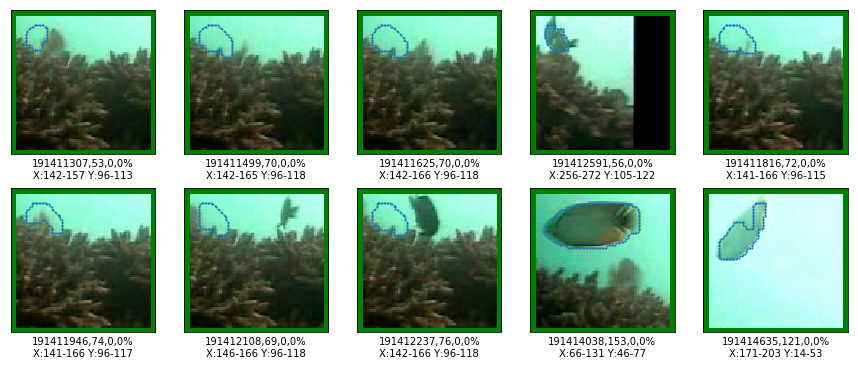

In [3]:
h = 0
w = 5
d = 2
g = 10
t = h + d * w 
plotStuff(info, clip, hasContour, contour, movid, limit_lower=h, limit_upper=t, width=w, gap=g, classify=True)

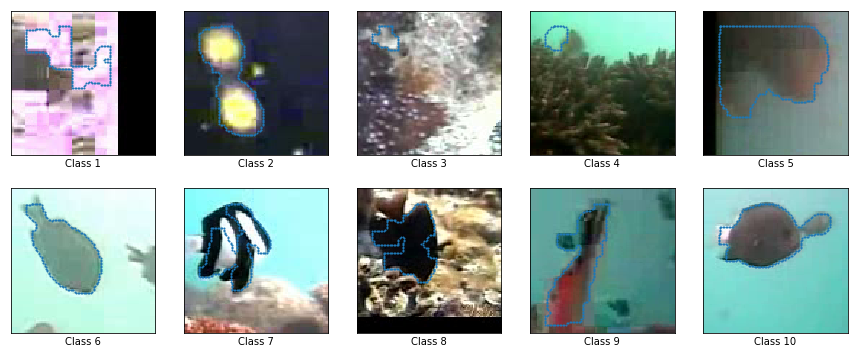

In [12]:
def printClassExamples():
    samp_vids = [343 ,638,6,5,13 ,146,153,153,198,134]
    samp_fram = [1000,80 ,0,0,136,301,290,290,60 ,420]
    
    plt.subplots(2,5,figsize=(15,6))
    
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("Class {0}".format(i+1))
        info, clip, hasContour, contour, fish_id, frames = loadVideo(movs[samp_vids[i]])
        plt.imshow(clip[samp_fram[i]])
        cline = contour[samp_fram[i]]
        thisContour = getContour(cline, return_what="Normalized")
        plt.scatter(thisContour[:,0],thisContour[:,1],s=1)
    plt.show()
        
printClassExamples()

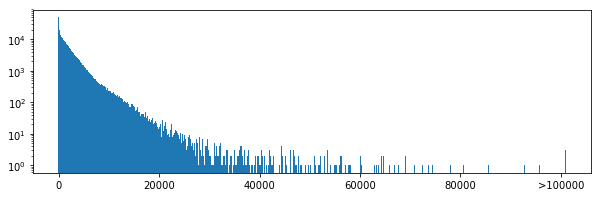

In [37]:
bins = np.append(np.arange(0,101000,100),300000)
plt.figure(figsize=(10,3))
plt.bar(np.arange(1010),np.histogram(movs_length, bins)[0],1)
ax = plt.gca()
ax.set_xticklabels([0,0,20000,40000,60000,80000,">100000"])
ax.set_yscale("log")
# ax.set_xlabel("Number of Frames/Detection")
# ax.set_ylabel("Nu")
plt.show()

In [43]:
sums = np.sum(movs_length)
sums30k = np.sum(movs_length[movs_length>=5000])
print(sums30k*1.0/sums)
print(np.sum(movs_length>=30000))

0.427325810465
398


['13b0bd6d7c9fc8e096f04bf408e850e9#201104170900' '37' '0']

1360 out of 3205 is recognized as a fish
None: 198
Class 1: 23
Class 2: 0
Class 3: 1280
Class 4: 13
Class 5: 30
Class 6: 66
Class 7: 338
Class 8: 956
Class 9: 301
Class 10: 0

[3 9 3 3 9]


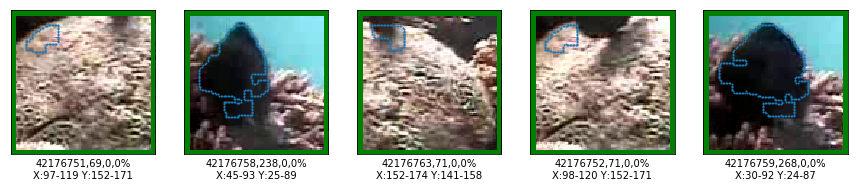

[3 3 9 8 3]


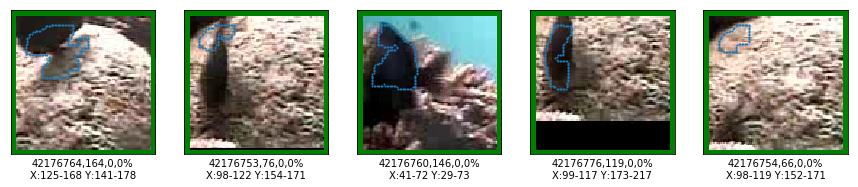

[8 8 3 8 3]


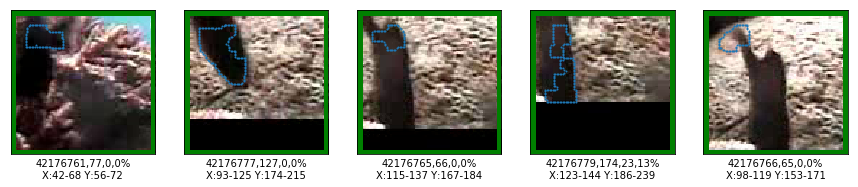

In [181]:
def loadGT(video_id, length):
    path = "/afs/inf.ed.ac.uk/user/s14/s1413557/f4k-2017-msc-master/matt-msc/workspace/gt/"+video_id+".f4kgt"
    with open(path) as f:
        line = f.readlines()
        line = line[0][1:-1]
        tags = line.split(",")
        gts = [None] * length
        for t in tags:
            try:
                left, right = t.split(":",1)
                gts[int(left.strip()[1:-1])-1] = int(right.strip())
            except Exception:
                print(t)
    return np.array(gts)

tr = np.arange(30598,30695)
picker = tr[7]
movid = movs[picker]
info, clip, hasContour, contour, fish_id, frames = loadVideo(movid)
print(movid)

gts = loadGT(movid[0], frames)
#print(gts.tolist())
gts[gts == None] = -1
gts += 1

fish = gts[gts>=6]
fish = fish[fish<=8]

print("")
print("{0} out of {1} is recognized as a fish".format(len(fish),len(gts)))
counts = np.histogram(gts,np.arange(0,12))[0]
#print(counts)
print("None: {0}".format(counts[0]))
for i in np.arange(1,11):
    print("Class {0}: {1}".format(i,counts[i]))
#print(np.arange(len(gts))[gts==0])
print("")

h = 1580
print(gts[h:h+5])
plotStuff(info, clip, hasContour, contour, movid, limit_lower=h, limit_upper=h+5, width=5, classify=True)
h+=5
print(gts[h:h+5])
plotStuff(info, clip, hasContour, contour, movid, limit_lower=h, limit_upper=h+5, width=5, classify=True)
h+=5
print(gts[h:h+5])
plotStuff(info, clip, hasContour, contour, movid, limit_lower=h, limit_upper=h+5, width=5, classify=True)

# PCA
---

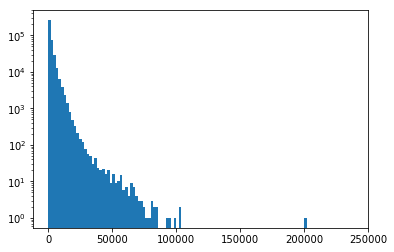

In [5]:
plt.hist(movs_length,np.arange(0,240000,2000),label="hst")
plt.gca().set_yscale('log')
plt.show()

In [6]:
ranges = loadRange()
pca = loadPCA(ranges)

In [7]:
component = pca.components_
eigens = pca.explained_variance_
eigenratio = pca.explained_variance_ratio_

In [8]:
print(ranges)

[[  5.00000000e-02   4.65053763e-02   4.36672968e-02 ...,   2.62850000e+02
    3.35050000e+02   2.92000000e+02]
 [  9.50000000e-01   8.83602151e-01   8.29678639e-01 ...,   2.31215000e+03
    3.28795000e+03   2.59600000e+03]]


In [9]:
print(eigenratio.tolist()[:30])

[0.19046600453145254, 0.10418561944117845, 0.08991178903772701, 0.06988497541340548, 0.04642803589432593, 0.04098096972689149, 0.033655542946007505, 0.03011473427537491, 0.026031388598253952, 0.020426107901711843, 0.017458867173930012, 0.013825212723337102, 0.011867732225081978, 0.010908678827489516, 0.010050571648483128, 0.009363170861342399, 0.008660843204274557, 0.007536844578114386, 0.006842806418077072, 0.006362593580447671, 0.006066458290562876, 0.005643989369139039, 0.005372132695938067, 0.005273903415115154, 0.005117916679800234, 0.004689367432850034, 0.004434204593135072, 0.004188900622277559, 0.003946165053737731, 0.0037851649742984155]


In [10]:
print(sum(eigenratio[:100]))

0.907850410557


In [11]:
feature_names = featureNames()
component = component[:50,:]
pt = np.max(np.abs(component),0)
ptall = np.max(np.abs(component))
throw = pt < (ptall*0.01)
throwindex = np.arange(0,2655)[throw]
throwfeature = np.array(feature_names)[throw]

fr = np.vstack((pt/ptall,feature_names))

print(len(throwindex))
print(fr[:,2631:2635])
#print(throwindex+1)
#print(throwfeature)

762
[['0.00427090682512' '0.00053754073893' '0.000105159648332'
  '7.57590810223e-05']
 ['Erraticity 1' 'Erraticity 2' 'Erraticity 3' 'Erraticity 4']]


In [4]:
print(movs[23472])
idddd = movs[23472][0]
pcatransformed = np.load("/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/features/0/0f/"+idddd+".pcaFeature.npy")

['0f13ebb537ca30244623586a5faad81b#201108241230' '38' '1']


In [5]:
asd = pd.DataFrame(pcatransformed)
asd.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,...,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000,5988.000000
mean,-0.531499,-0.611799,-1.220866,0.200187,-0.637263,-0.499491,-0.107724,0.086304,-0.138881,0.101023,...,0.002392,-0.026374,-0.015258,0.003632,-0.017224,0.001578,-0.006410,-0.036753,0.001536,-0.034567
std,3.405892,2.017961,1.290732,1.567868,1.170864,1.112636,0.975522,1.063756,0.816666,0.963616,...,0.146018,0.157807,0.177204,0.177380,0.172141,0.133363,0.145921,0.171594,0.148151,0.124975
min,-4.854966,-4.937241,-4.877994,-3.901056,-4.615034,-4.304048,-3.128237,-3.658968,-2.299950,-2.492004,...,-0.648195,-0.623171,-0.750269,-0.695966,-0.711816,-0.641212,-0.556148,-0.687554,-0.603685,-0.760095
25%,-3.473433,-1.984418,-2.025675,-0.965033,-1.426102,-1.207381,-0.619826,-0.536219,-0.683299,-0.614196,...,-0.093087,-0.135492,-0.125134,-0.113633,-0.131503,-0.084903,-0.101543,-0.147515,-0.091563,-0.108442
50%,-2.005199,-0.967034,-1.258780,-0.302438,-0.563655,-0.630275,0.002319,0.311926,-0.310218,0.073128,...,-0.004832,-0.026891,-0.016926,0.008182,-0.030975,0.000221,-0.007593,-0.022908,-0.001810,-0.031262
75%,2.376680,0.429735,-0.469512,1.271378,0.213195,0.082290,0.415592,0.826348,0.255632,0.834581,...,0.097826,0.077397,0.086668,0.125280,0.087344,0.082124,0.088375,0.083432,0.096487,0.042819
max,6.649833,6.725243,5.368467,5.619388,3.404382,4.127459,4.243876,3.213175,4.532563,3.422756,...,0.602124,0.683806,0.878653,0.681109,0.719882,0.641649,0.563306,0.631414,0.886331,1.037766


# Timetest

In [26]:
#Placeholder tookit
time = datetime.now()
print("Took total of {0}".format(datetime.now() - time))
time = datetime.now()

Took total of 0:00:00.000131


In [10]:
time = datetime.now()
for picker in range(frames):
    if hasContour[picker]:
        image1 = clip[picker]
        thiscontour = getContour(contour[picker])
        mask = np.full(image1.shape, 0, dtype=np.uint8)
        cv2.fillPoly(mask, np.array([thiscontour], dtype=np.int32), (255,)*3)
        image2 = cv2.cvtColor(image1,cv2.COLOR_RGB2YUV)
        image3 = normalizeRGB(image2)[:,:,0]
        image4 = cv2.bitwise_or(cv2.bitwise_not(mask),image1)
        image5 = cv2.cvtColor(image4,cv2.COLOR_RGB2YUV)
        image6 = normalizeRGB(image5)[:,:,0]
        image7 = cv2.bitwise_and(mask,image1)
        image8 = cv2.cvtColor(image7,cv2.COLOR_RGB2YUV)
        image9 = normalizeRGB(image8)[:,:,0]
    print("Image {1} took total of {0}".format(datetime.now() - time,picker+1),end='\r')
print("Took total of {0}              ".format(datetime.now() - time))

Took total of 0:00:03.539000              


# Testing Algs Output
---

In [5]:
#not very useful

def imageSame(image1,image2,offset=0):
    lowerBound = image2 - np.full(image2.shape,offset)
    upperBound = image2 + np.full(image2.shape,offset)
    result = np.logical_and(image1>=lowerBound,image1<=upperBound)
    return np.sum(result)

def metricRepeating(clip,ras=True):
    if len(clip)<10:
        return 0
    
    scores = []
    for i in np.arange(0,10):
        for j in np.arange(i+1,10):
            scores.append(imageSame(clip[i],clip[j]))
    if ras:
        return np.sqrt(np.average(np.power(scores,2)))
    else:
        return np.average(scores)

In [77]:
matt_features = getMattFeatures(info, clip, hasContour, contour, fish_id, print_info=True, ret_normalized_erraticity=False)

Calculate 2 feature took total of 0:00:00.105477
116 out of 118 feature not calculated


In [78]:
print(matt_features.shape)

(118, 29)


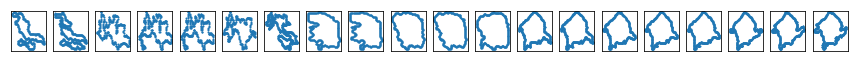

In [11]:
path = '/afs/inf.ed.ac.uk/group/ug4-projects/s1413557/line107340.txt'
if os.name == "nt":
    path = 'E:/line107340.txt'
plotContourFromOriginalFile(path,limit_amount=20, add_milk=False)

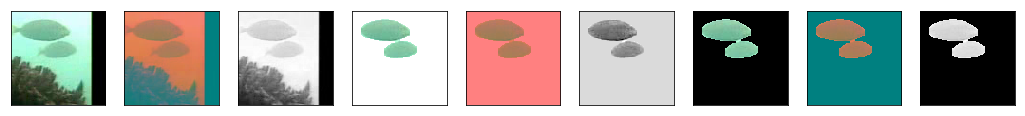

In [5]:
picker = 177
showTransformedImage(picker, clip, hasContour, contour)

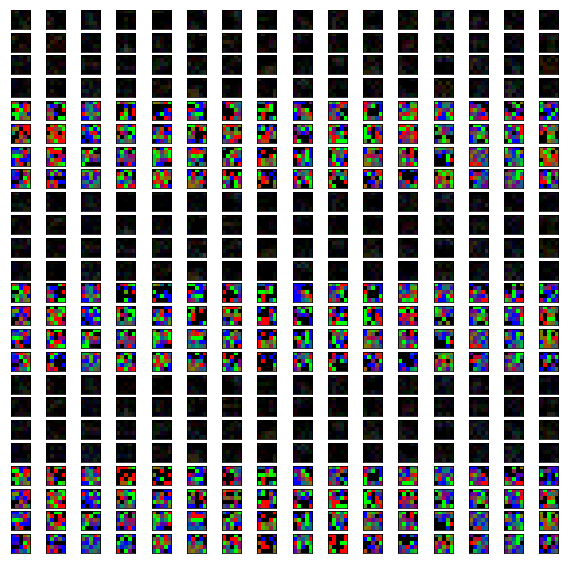

In [11]:
printCNNweight()

In [12]:
printCameras()

37,1,'NPP-3','3.6mm F1.8 1/3 inches CCD',0,5
38,3,'NPP-3','3.6mm F1.8 1/3 inches CCD',0,5
39,4,'NPP-3','3.6mm F1.8 1/3 inches CCD',0,5
40,1,'HoBiHu','3.6mm F1.8 1/3 inches CCD',0,5
41,2,'HoBiHu','3.6mm F1.8 1/3 inches CCD',0,5
42,2,'NPP-3','3.6mm F1.8 1/3 inches CCD',0,5
43,3,'HoBiHu','3.6mm F1.8 1/3 inches CCD',0,5
44,1,'LanYu','3.6mm Iris:auto 1/3 inches CCD; white LED night sight',0,15
46,2,'LanYu','3.6mm Iris:auto 1/3 inches CCD; white LED night sight',0,15


In [ ]:
movs = loadMovids()
time = datetime.now()
for i in range(1584):
    __, clip2, __, __, __, __ = loadVideo(movs[i],print_info=False,print_time=True)
    print("Checked Video: {0}  ID: {1}, took: {2}".format(i, movs[i][0],datetime.now()-time), end='\r')

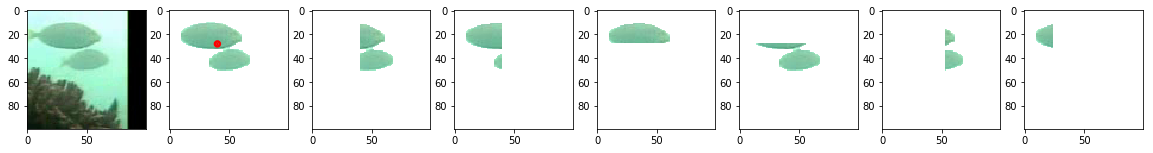

In [6]:
picker = 5
picker2 = 177
printSeperateFish(picker,picker2)

In [13]:
# Took a total of 0:18:53.200900           
# FEIF return 467977 true
# FEIF return 2801786 false
# total of 0 detection have no contour
# Will took about 80 hours to finish all.

reject = 467977
kept = 2801786
no_contour = 0
summu = reject+kept+no_contour
print("Maybe we only need to calculate {0:.3f}% of the features.".format(100.0*kept/summu))
print("Rejected {0:.3f}% of the features.".format(100.0*reject/summu))
print("{0:.3f}% of the features have no Contour.".format(100.0*no_contour/summu))

Maybe we only need to calculate 85.688% of the features.
Rejected 14.312% of the features.
0.000% of the features have no Contour.


In [49]:
def secToTime(seconds, mode = "full"):
    days = int(seconds // 86400)
    seconds = seconds % 86400
    hours = int(seconds // 3600)
    seconds = seconds % 3600
    minutes = int(seconds // 60)
    seconds = int(seconds % 60)
    if mode == "hour":
        return " {0} Hours".format(24*days+hours)
    return " {0} Days {1} Hours {2} Minute {3} Seconds".format(days,hours,minutes,seconds)

In [50]:
total_features = 839000000
feif_reduction_rate = 0.66272
videos = 396901

qiqi_time_find_track = 19.2
qiqi_time_extraction = 110.1 
qiqi_time_image_preprocess = 70.0
qiqi_total = qiqi_time_find_track + qiqi_time_extraction + qiqi_time_image_preprocess
qiqi_core_used = 32 #32 out of 40
qiqi_core_used_minimal = 8 #If core is poorly utilized
qiqi_feature_used = 961
qiqi_videos = 455993

my_time_find_track = 0.509453
my_time_extraction = 37 * 60 + 22.1
my_time_image_preprocess = 6.751748
my_total = my_time_find_track + my_time_extraction + my_time_image_preprocess
my_core_used = 1
my_core_used_maximal = 2
my_feature_used = 4716
my_feature_used_actual = 4103

used_total = qiqi_total
used_total2 = my_total

print("Qiqi's calculated runtime using original code (32 core):")
print(secToTime(used_total*qiqi_videos, mode="hour"))
print(secToTime(used_total*qiqi_videos))

print("\nQiqi's calculated runtime using original code (32 core) (corrected total):")
print(secToTime(used_total/qiqi_feature_used*total_features, mode="hour"))
print(secToTime(used_total/qiqi_feature_used*total_features))

print("\nSingle-core Runtime using original code:")
print(secToTime(used_total*qiqi_core_used/qiqi_feature_used*total_features, mode="hour"))
print(secToTime(used_total*qiqi_core_used/qiqi_feature_used*total_features))

print("\n300-core Runtime using original code:")
print(secToTime(used_total*qiqi_core_used/300/qiqi_feature_used*total_features, mode="hour"))
print(secToTime(used_total*qiqi_core_used/300/qiqi_feature_used*total_features))

print("\nMy calculated runtime (1 process, uses about 4*40% = 1.6 core):")
print(secToTime(used_total2/my_feature_used*total_features, mode="hour"))
print(secToTime(used_total2/my_feature_used*total_features))

print("\nMy calculated runtime (reduced with FEIF):")
print(secToTime(used_total2/my_feature_used_actual*total_features*feif_reduction_rate, mode="hour"))
print(secToTime(used_total2/my_feature_used_actual*total_features*feif_reduction_rate))

print("\n300-core runtime using my code:")
print(secToTime(used_total2/300*my_core_used/my_feature_used_actual*total_features*feif_reduction_rate, mode="hour"))
print(secToTime(used_total2/300*my_core_used/my_feature_used_actual*total_features*feif_reduction_rate))

print("\n300-core runtime using my code (worst-case: 2 process per machine):")
print(secToTime(used_total2/300*my_core_used_maximal/my_feature_used_actual*total_features*feif_reduction_rate, mode="hour"))
print(secToTime(used_total2/300*my_core_used_maximal/my_feature_used_actual*total_features*feif_reduction_rate))

print("\nMy process's average runtime per feature:")
print(my_total/my_feature_used_actual)

Qiqi's calculated runtime using original code (32 core):
 25244 Hours
 1051 Days 20 Hours 16 Minute 44 Seconds

Qiqi's calculated runtime using original code (32 core) (corrected total):
 48332 Hours
 2013 Days 20 Hours 57 Minute 27 Seconds

Single-core Runtime using original code:
 1546654 Hours
 64443 Days 22 Hours 38 Minute 31 Seconds

300-core Runtime using original code:
 5155 Hours
 214 Days 19 Hours 30 Minute 55 Seconds

My calculated runtime (1 process, uses about 4*40% = 1.6 core):
 111159 Hours
 4631 Days 15 Hours 3 Minute 34 Seconds

My calculated runtime (reduced with FEIF):
 84673 Hours
 3528 Days 1 Hours 26 Minute 35 Seconds

300-core runtime using my code:
 282 Hours
 11 Days 18 Hours 14 Minute 41 Seconds

300-core runtime using my code (worst-case: 2 process per machine):
 564 Hours
 23 Days 12 Hours 29 Minute 22 Seconds

My process's average runtime per feature:
0.548223543992


# Windows Test Code below, cuz no library loves windows.

In [5]:
f4k_features = np.load("C:\Users\YuJianmeng\Desktop\\000091a58183e0358d5c3f8716c8491a#201101151720.f4kfeature.npy")
matt_features = np.load("C:\Users\YuJianmeng\Desktop\\000091a58183e0358d5c3f8716c8491a#201101151720.mattfeature.npy")
feif_mask = np.load("C:\Users\YuJianmeng\Desktop\\000091a58183e0358d5c3f8716c8491a#201101151720.feif.npy")
features = np.column_stack((f4k_features,matt_features))

In [6]:
pdFeatures = pd.DataFrame(features)
pdFeatures.describe()

,0,1,2,3,4,5,6,7,8,9,...,2645,2646,2647,2648,2649,2650,2651,2652,2653,2654
count,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,...,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000,4716.000000
mean,0.047761,0.004730,0.005602,0.006380,0.008325,0.011507,0.017112,0.026748,0.043515,0.067123,...,1377.132952,476.085666,1424.459924,455.829729,1351.825488,544.440204,1530.262723,739.238974,772.665818,840.651612
std,0.158739,0.015063,0.016333,0.017598,0.021635,0.026509,0.036185,0.050325,0.071256,0.090752,...,772.806095,239.856302,819.512998,274.686283,771.661224,346.217531,843.367173,457.455999,421.512308,533.210618
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,968.000000,367.750000,980.000000,312.000000,931.750000,351.000000,1095.000000,479.000000,571.000000,516.750000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005845,0.021610,...,1402.000000,502.000000,1433.000000,437.000000,1368.000000,512.500000,1571.500000,703.000000,785.000000,801.000000
75%,0.002268,0.000000,0.000000,0.002320,0.005452,0.010506,0.017805,0.031843,0.061407,0.112274,...,1817.000000,634.000000,1892.000000,599.000000,1797.000000,716.000000,2025.250000,976.250000,1022.000000,1127.250000
max,0.916129,0.178082,0.171642,0.214286,0.295455,0.373913,0.437500,0.517241,0.516129,0.558824,...,5619.000000,1132.000000,6129.000000,1642.000000,5614.000000,2024.000000,5872.000000,2554.000000,2977.000000,2856.000000


In [ ]:
if os.name == "nt":    
    import matlab.engine
    eng = matlab.engine.start_matlab()
    eng.addpath(r'C:/Users/YuJianmeng/f4k/matt-msc/workspace/f4k/fish_recog',nargout=0)

In [ ]:
if os.name == "nt":
    
    i = 0
    thiscontour = getContour(contour[i])
    mask = np.full(image.shape, 0, dtype=np.uint8)
    cv2.fillPoly(mask, np.array([thiscontour], dtype=np.int32), (255,)*3)
    image = clip[i]

    eng.workspace['A'] = image.tolist()
    print(len(image.tolist()))

    (c,d) = eng.generateFeatureFromPython(image.reshape(1,-1).tolist(),full_fish.reshape(1,-1).tolist(),nargout=2)

    print(np.array(c,dtype="double").shape)

In [ ]:
if os.name == "nt":
    eng.exit()
    eng.quit()
    del eng

# Below code only work on DICE. (#JustPyMatlabThings)

In [7]:
if os.name != "nt":
    import pymatlab
    session = pymatlab.session_factory('matlab -nodisplay')
    session.run('cd /afs/inf.ed.ac.uk/user/s14/s1413557/f4k-2017-msc-master/matt-msc/workspace/f4k/fish_recog')

In [8]:
if os.name != "nt" and False:
    #Outdated
    time = datetime.now()
    for i in range(4716):
        thisContour = np.int32([getContour(contour[i])])
        image = clip[i]
        full_fish = np.full((100,100), 0, dtype=np.uint8)
        cv2.fillPoly(full_fish, thisContour, (255,))
        session.putvalue('A',image)
        session.putvalue('B',full_fish)
        session.run('[C, D] = feature_generateFeatureVector(A,B,false)')
        c = session.getvalue('C')
        #d = session.getvalue('D')
        print("Process {0} image took {1}".format(i,datetime.now() - time), end='\r')
    print("Took a total of {0}           ".format(datetime.now() - time) )

In [11]:
time = datetime.now()

hasCL = np.sum(hasContour)
rgbImgs = [None]*hasCL
binImgs = [None]*hasCL
index = 0
for i in range(frames):
    if hasContour[i]:
        rgbImgs[index]=clip[i]
        binImgs[index]=np.full((100,100), 0, dtype=np.uint8)
        thisContour = np.int32([getContour(contour[i])])
        cv2.fillPoly(binImgs[index], thisContour, (255,))
        index += 1
        
print("Took a total of {0}           ".format(datetime.now() - time) )
session.putvalue('A',rgbImgs)
session.putvalue('B',binImgs)
print("Took a total of {0}           ".format(datetime.now() - time) )

session.run('C = feature_batchGenerateFeatureVector(A,B)')
print("Took a total of {0}           ".format(datetime.now() - time) )
c = session.getvalue('C')
print("Took a total of {0}           ".format(datetime.now() - time) )

Took a total of 0:00:00.340644           
Took a total of 0:00:02.209818           


RuntimeError: Error from Matlab: Error: MATLAB:UndefinedFunction with message: Undefined function 'feature_batchGenerateFeatureVector' for input arguments of type 'uint8'.


In [86]:
print(c.shape)

(2626,)


In [12]:
if os.name != "nt":
    del session

---